# Trans E

## Summary  

For the TransE model, using the L2 norm in our case has better performance than using the L1 norm. The loss gets to 0 at the first training epoch with L1 regularization, and the model stops learning(underfitting) too early. L2 has its nature to force values to be small, but not 0. This allows the TransE model with L2 regularization to learn more. After analyzing the impact of embed dimensions, regularization methods, margins and learning rates on the TransE model, we choose “Norm: L2, Embed Dimension: 200, Learning Rate: 1.0, Margin: 1.75 with SGD optimizer. The SGD has momentum 0.9 and weight decay 1e-5” as our final model. For the given questions: <USA, capital, ?> and <USA, ?. North America>, our final model has successfully understood the “capital”, it could infer capitals of different countries but fail to point out the capital for the United States of America, our given head entity. As for the second question, the ideal answer would be “USA is part of North America”, however, our model fails to calculate relationships that are more closely to “part of”. The inferences that are related to “part of” would be: “applies to jurisdiction”, “located in the administrative territorial entity” and “country”. As “country” is a subproperty of “located in the administrative territorial entity”, we could assume that the model still has not finished learning. In addition, as mentioned in the experiment observations, the political/region related information can be learnt at an early stage of training(with small max epoch). With large epoch amounts, the geographically related information becomes less important, and the model starts to pick up and remember social/society related connections.   

During the process of finishing this report, I had a high fever and a serious cold, and therefore there was not enough time left to implement and test any enhancement in Word2Vec and TransE models. An obvious limitation from our experiments suggests that basic Word2Vec and TransE models both have difficulties in word sense ambiguous elimination. It would be a topic that is worth exploring. Also inspired by an article “Improving Knowledge Graph Embedding Using Affine Transformations of Entities Corresponding to Each Relation”, we could also spend some time later to try out the idea. 


## 1.1 TransE Model  

To represent knowledge, knowledge graphs are commonly used. Usually, we use a triple (head, relation, tail) to represent knowledge. Here, head and tail are entities. For example, (sky tree, location, Tokyo). Our task here, link prediction, is a typical downstream task for knowledge representation.   
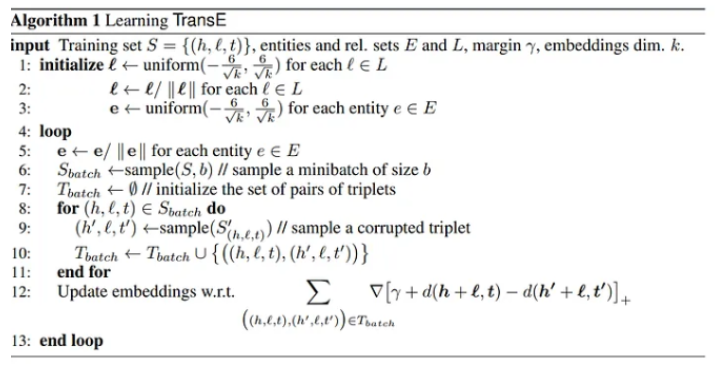  

In this report, we will focus on a preliminary method for entity prediction task known as TransE, an energy based model that learns continuous, low-dimensional embedding of entities and relationships by minimizing a margin-based pair-wise ranking loss.  

The code implementation on score calculation and loss calculation is inspired by a github project “TransE-PyTorch”. For the loss calculation, we scripted based on the source code and documentation of the torch MarginRankingLoss. Note that when calculating positive and negative scores, we need to normalize the embeddings with the L2 norm. And the final score(distance) is calculated based on whether L1 or L2 norm is specified in the model configuration stage.    

Below attached code snippets for score and loss calculation.  

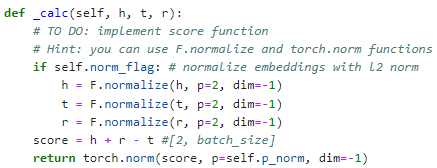  

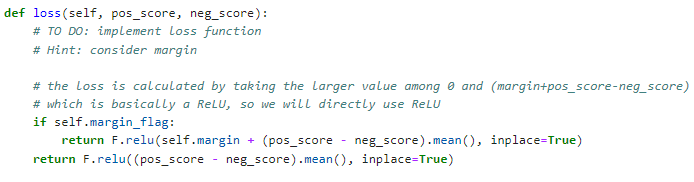  

In the following experiments, we will investigate how hyperparameters, such as epochs, learning rates, embed dimensions, margins and regularization methods can affect the model performance. In addition, we will check if using Adam as the training optimizer could improve the TransE model. Based on the assignment requirements, we take pairs (Q30, P36) and (Q30, Q49) as examples to analyze the model learning quality.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from load_data import PyTorchTrainDataLoader
import ctypes
import os
import time
import numpy as np

from load_data import PyTorchTrainDataLoader
from TransE import Config, to_var, TransE

import matplotlib.pyplot as plt

## 1.2 Embed Dimension and L1/L2 Regularization

We will start with in total 100 batches per epoch, 10 epochs for training, margin 1.0 and learning rate 1.0. The final model will have an early stop mechanism, but this mechanism will not be in the parameter tune stage . SGD without momentum or decay is the model optimizer.  

An embedding is a vector representation of a word/relationship in a high-dimensional space. The dimensionality of word embedding is a crucial factor in determining the quality and effectiveness of the embedding. The dimensionality of the word embedding represents the total number of features that are encoded in the vector representation.  

Deciding on the appropriate dimensionality for a word embedding depends on several factors, such as the size and nature of the dataset we are using, the specific NLP task we are working on, and the computational resources available to us.  

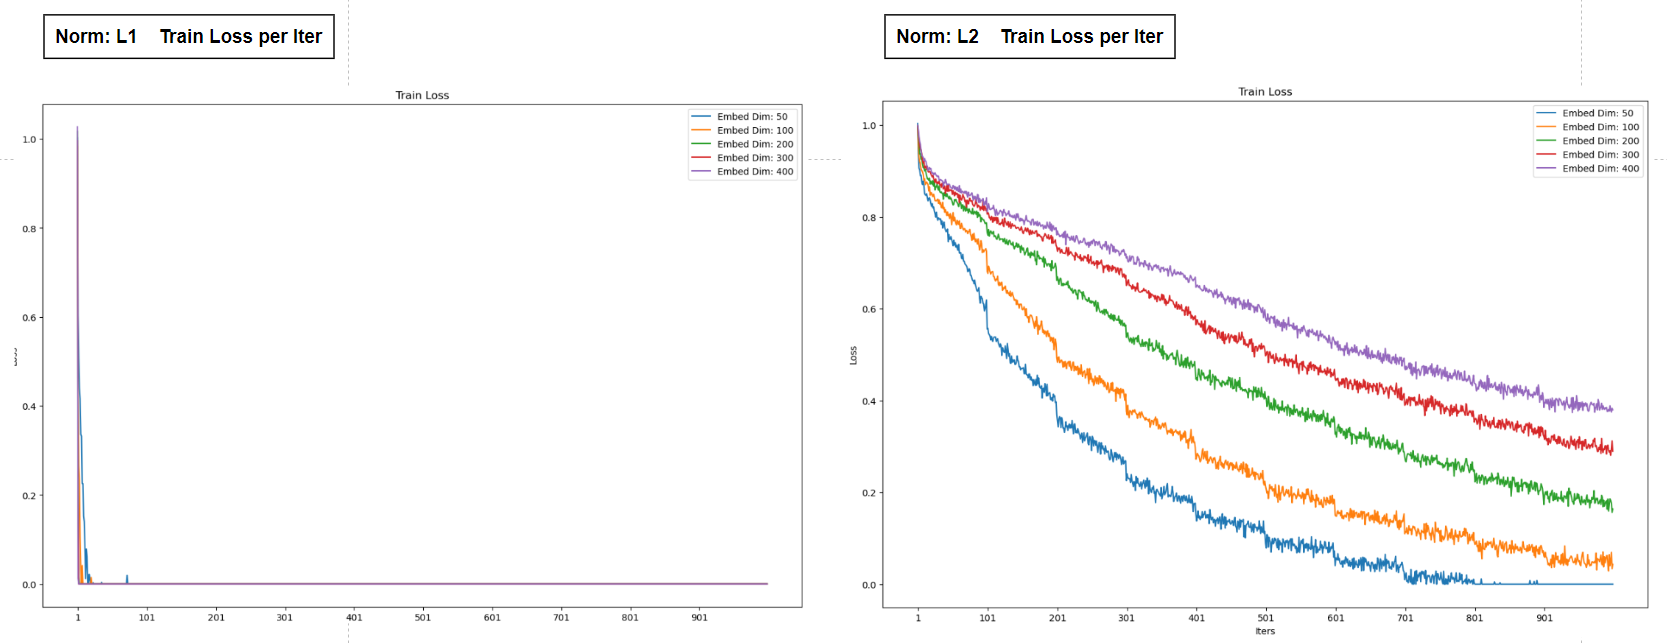  

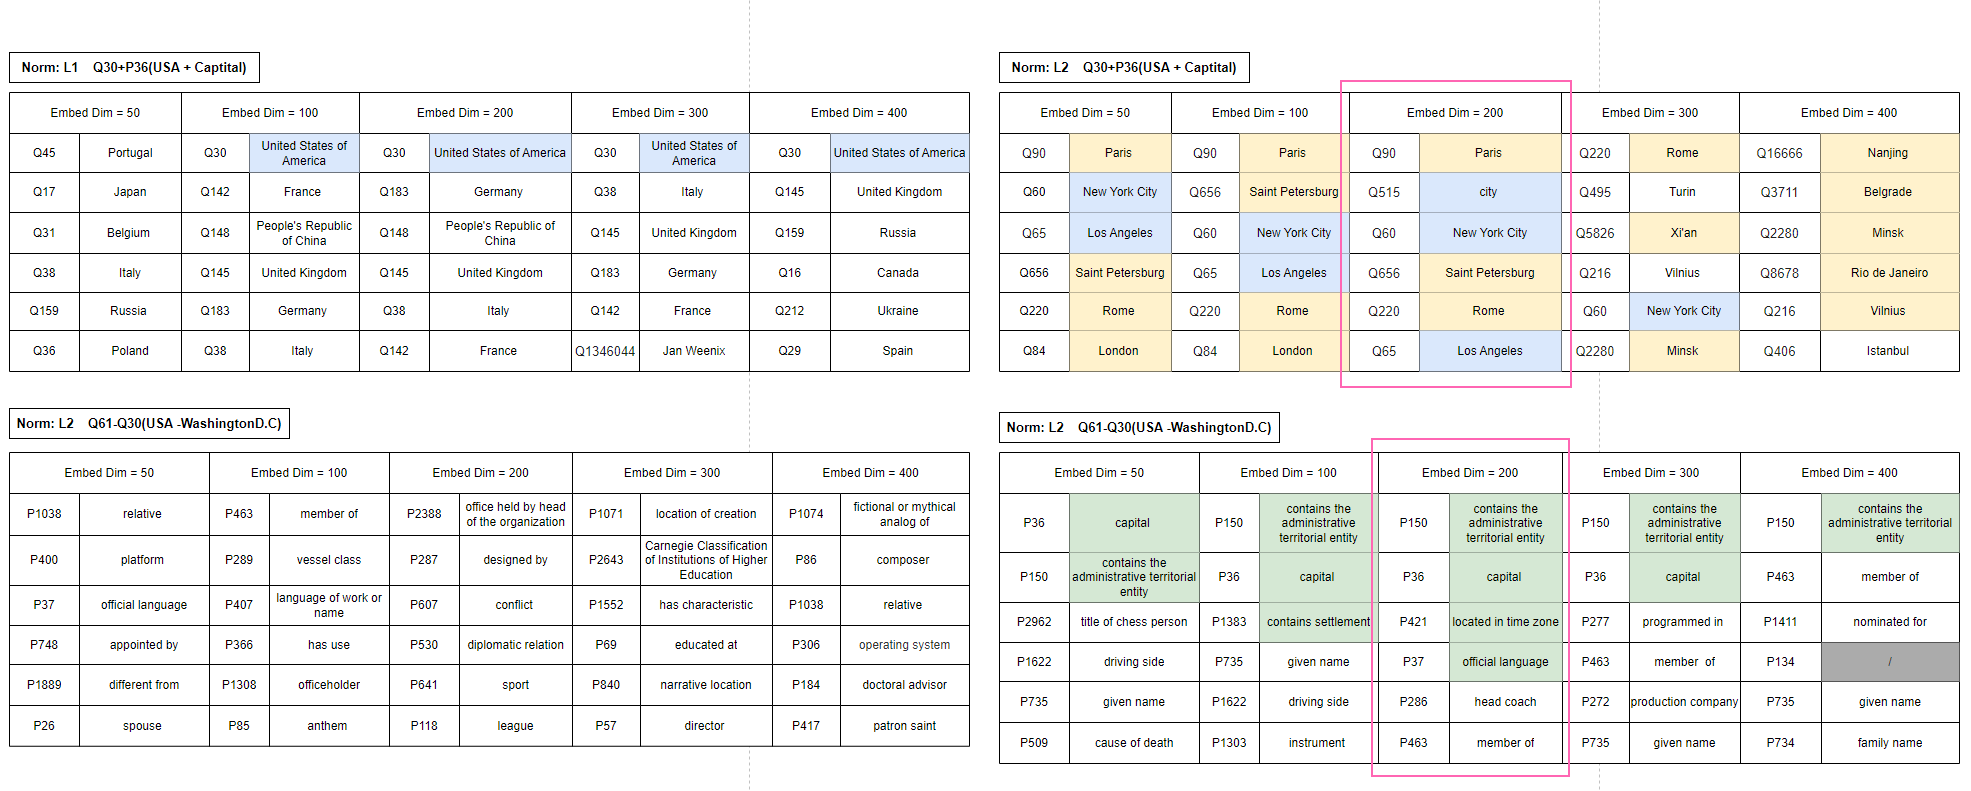  

<i>Blue: USA related; Yellow: Capital related; Green: Capital and administrative territorial  related.</i>  

<b>Observations:</b>  
1. The training loss gets to 0 at an early stage of training with L1 norm; Although there exists extreme small fluctuations before the first epoch finishes, the loss is still close to 0. That is, the model is not learning much. The diagrams of tail entity and relationship predictions for L1 norm models can also verify the analysis above. Not much useful/important relationship for the pair [USA(Q30), Capital(P36), Washington D.C.(Q61)] are acknowledged by the model. When we do “USA - WishingtonD.C.”, not much region or administrative relationships are extracted, instead, the model calculates more about the relationship between people or entities. This is also the reason when we use “USA + Capital” to inference WashingtonD.C., most of the outcomes are countries.
2. L2 norm models have better performances. The loss does not get down to 0, and except when the embed dimension is set to 50, other L2 models all still have a downward trend. The model has not fully converged, and later on we will try to apply larger learning rates. When doing “USA + Capital” inference, the tail entities are mostly cities that are capitals or were once capitals. USA cities also pop up in the top-6 most related list. The learning direction is correct, we just need to tune the model so that the connection between America and capital could be strengthened.
3. TransE models with L1 norm and L2 norm have huge differences. From the above diagrams, we assume that the L2 norm works better with our dataset and task. L1 regularization penalizes the sum of absolute values of the weights, whereas L2 regularization penalizes the sum of squares of the weights. The L1 regularization solution is sparse. The L2 regularization solution is non-sparse.The L1 regularization is a form of feature selection, because when we assign a feature with a 0 weight, we’re multiplying the feature values by 0 which returns 0, eradicating the significance of that feature. If the input features of our model have weights closer to 0, our L1 norm would be sparse. L2 regularization on the contrary, combats overfitting by forcing weights to be small, but not making them exactly 0. That is,  less significant features for predicting would still have some influence over the final prediction, but it would only be a small influence. This to some extent explains the loss graph above, why L1 norm models get to 0 so quickly and most of the time only the first entity in the inference tail entities has some connections to the given conditions.
4. Since the inferences generated by L1 norm models are almost non-correlated to the given pair, we will mainly analyze the impact of embed dimensions with L2 norm models. The higher the embed dimension is, the slower the model converges. The loss diagrams also suggest that the current learning rate is too small for the model to start actual learning immediately.
5. From a personal perspective, the result of “USA - Washington D.C.” should be P36(capital) and P150(contains the administrative territorial entity). With embed dimensions 50, 100, 200, and 300, both these two relationships have been inference out. When the embed dimension is set to 400, the model fails to calculate the “capital” relationship, which should be the top-1 correlated answer. One potential reason could be the model still has a long way to go before converging. Another potential reason would be the “curse of dimensionality”, a phenomenon in which the data get too sparse and the model easily gets overfitted and cannot generalize well.
6. When the embed dimension is set to 200, it has the most inferences that hit some of the closely related entities/relationships. Therefore we will use this value for the later experiments.

## 1.3 Margin   

Given the fact the L1 norm models have comparatively weaker performances from Section 2.1, we will mainly focus on investigating margin impact on L2 norm models performances.  

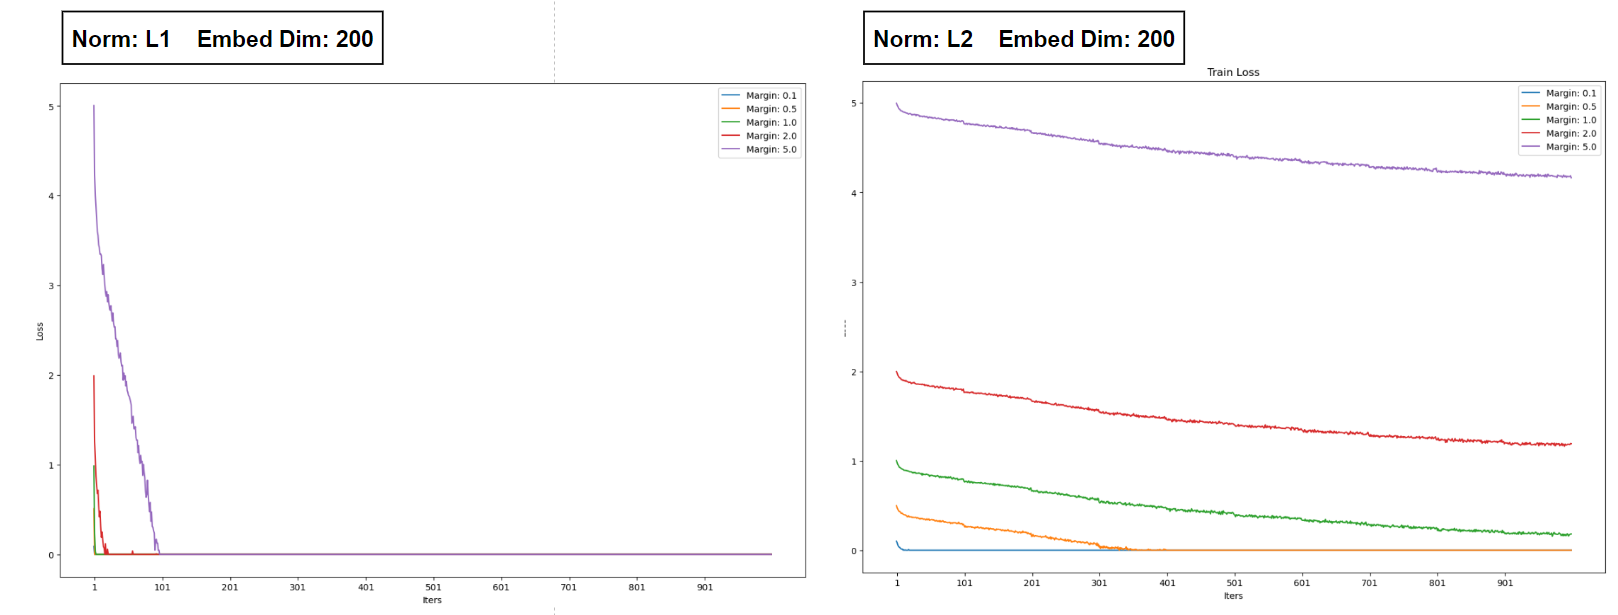

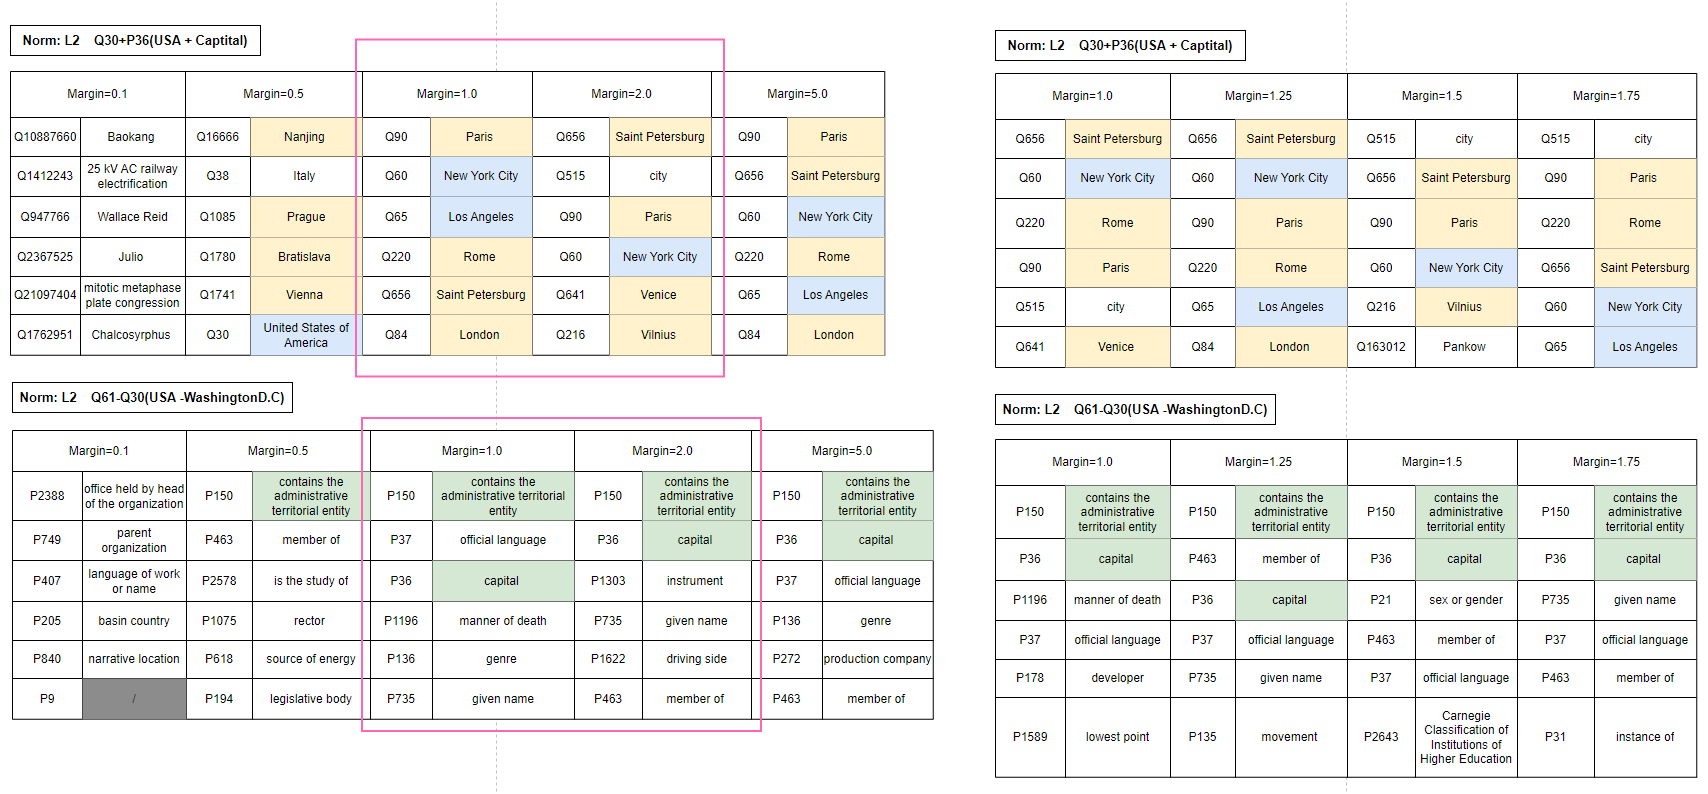  
<i>Blue: USA related; Yellow: Capital related; Green: Capital and administrative territorial  related.</i>  

<b>Observations:</b>  
1. We could see more details on the learning process for L1 norm models with higher margins. However, all L1 norm models have loss approaches to 0 at the first epoch. We could make an assumption that, same as in Section 2.1, L1 norm model performances would not enhance too much since they stop learning after the first epoch.  
2. For both L1 norm and L2 norm models, the greater the margin is, the slower the model converges. In addition, margin values seem also to somehow settle  bottom(minimum) loss values after a L2 norm model converges. This is because the L2 regularization tries to approach the loss to 0, rather than set it to 0. And margin is directly added to this positive and negative score difference.  
3. Originally, we tested margin values of [0.1, 0.5, 1.0, 2.0, 5.0] on L2 norm models. From the inference diagrams of (USA, capital, Washington D.C.), we could see that the models have comparatively good performances(most top-6 inferences that connect to USA or capital) when the margin is equal to 1.0 or 2.0 or 5.0. In order to get more details on how margin affects the learning results, we tested margin values of [1.25, 1.5, 1.75] in addition.
4. For margin values of [1.0, 1.25, 1.5, 1.75, 2.0], all L2 norm models have successfully answered the relationship between USA and Washington D.C. with the top2 most relative inference. The most frequent model responding to this question is: Washington D.C contains the administrative territorial entity of America, it is the capital of America. However, the relationship “capital” is not the first inference of the model, this is also the reason why the model fails to nominate “Washington D.C.” as the answer of “USA+capital”. We will eliminate margin=1.25 at this stage since the “capital” only ranks the thirds in its inference.
5. We will choose 2 L2 norm models for testing learning rates. Both 2 values below have answered “USA+capital” with most of the references related to capital or USA.  
   * Margin=1.75;  
   * Margin=1.0.  

## 1.4 Learning Rate  

As analyzed above, the current learning rate 1.0 is a bit too small. In this section we will use much larger learning rates and see how the model performs.  

The learning rates tested in this section are: [1.0, 3.0, 5.0, 10.0].  

Below images are the loss diagrams when the margin is set to 1.75 and 1.0. Given the same learning rate, higher margin values mean slower convergence. The loss curves with different learning rates all follow a similar trend, in each epoch the loss first decreases massively, then  fluctuates until entering the next epoch and decreases significantly again.    

When the margin is set to 1.0 and the learning rate is 10.0, the loss of the model approaches 0 at the fifth epoch. With the same margin, learning rate 5.0 converges at around epoch 7 and learning rate 3.0 converges at around epoch 9. Here, we only refer to convergence by the train loss curves. This is not quite accurate since in reality, we need also take into account the validation loss, and other model evaluation metrics.  

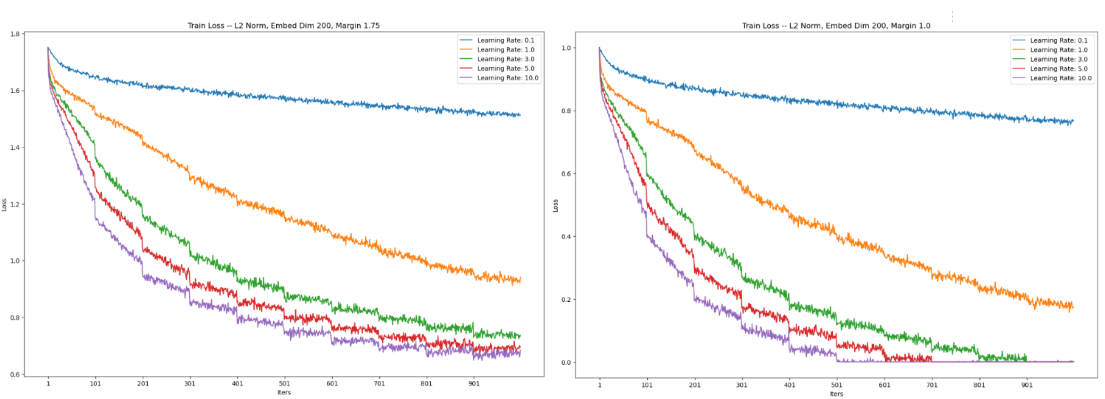  

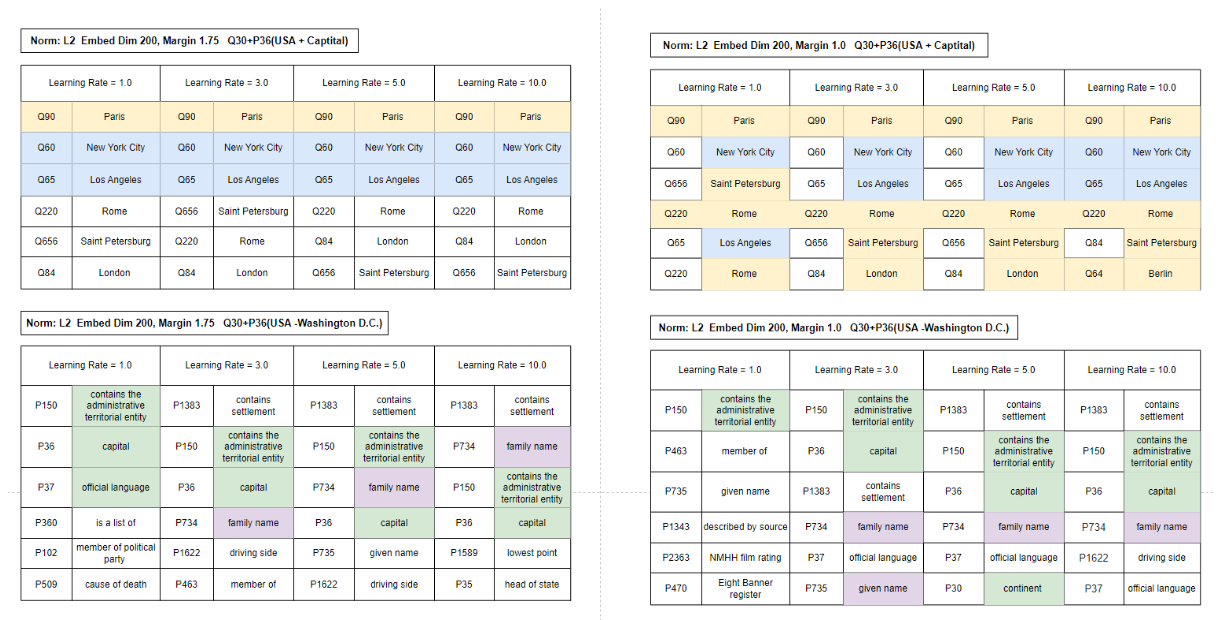  
<i>Blue: USA related; Yellow: Capital related; Green: Capital and administrative territorial related; Purple: Washington as a name.</i>  

Above are the inference diagrams of margin 1.75 and margin 1.0. The color code of highlights is also stated above.  

<b>Observations:</b>
1. When doing the “USA+Capital” inference, the nominate tail entity lists from the models are almost fixed, especially for the top 3(most related) tail entities. An interesting fact is that the model at this point understands what “capital” relationship means, since most of the answers are capitals of different countries. However, the model finds it difficult to find the exact capital for the United States of America.  
2. When doing the “USA-Washington D.C.” inference, as the learning rate grows, relationships that related to capital(ideal answer) or other administrative territorials are pushed down to less-importance ranks, whilst the relationships that link to Washington D.C. as a name starts to pop up more in the nomination list. This could be a potential cause of Observation 1 above. “Washington” as a word has great ambiguity. Our model mainly learned the entities and relationship types associated with it as a person's name, but did not learn the associated knowledge representations when it was used as a city name. Therefore, when we try to find the capital city of the United States of America, Washington D.C is not considered as a city. If we want significant improvements in this TransE model, we need to invoke stronger methods to eliminate word sense ambiguous.
3. We will use “Norm: L2, Embed Dimension: 200, Margin:1.75, learning rate:1.0” and “Norm: L2, Embed Dimension: 200, Margin:1.0, learning rate:10.0”. These two have similar inference results in the above diagrams, and their inference entities/relationship are more closely to the ideal answers we expect to have from the model prediction. The next section will be a simple test on different optimizers. Researches online have mentioned that a simple switch from using SGD as optimizer to Adam could bring in significant improvements to the TransE algorithm.


## 1.5 Optimizer  

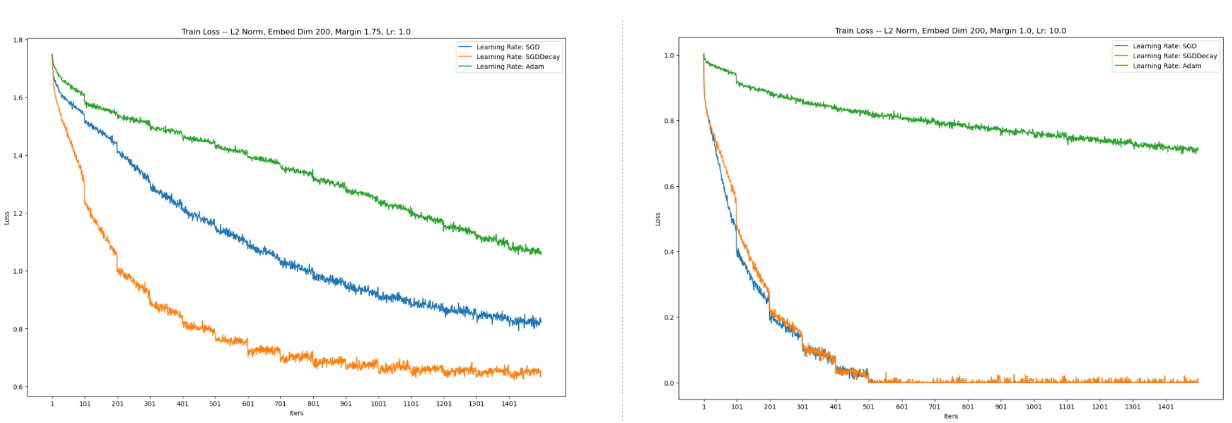  

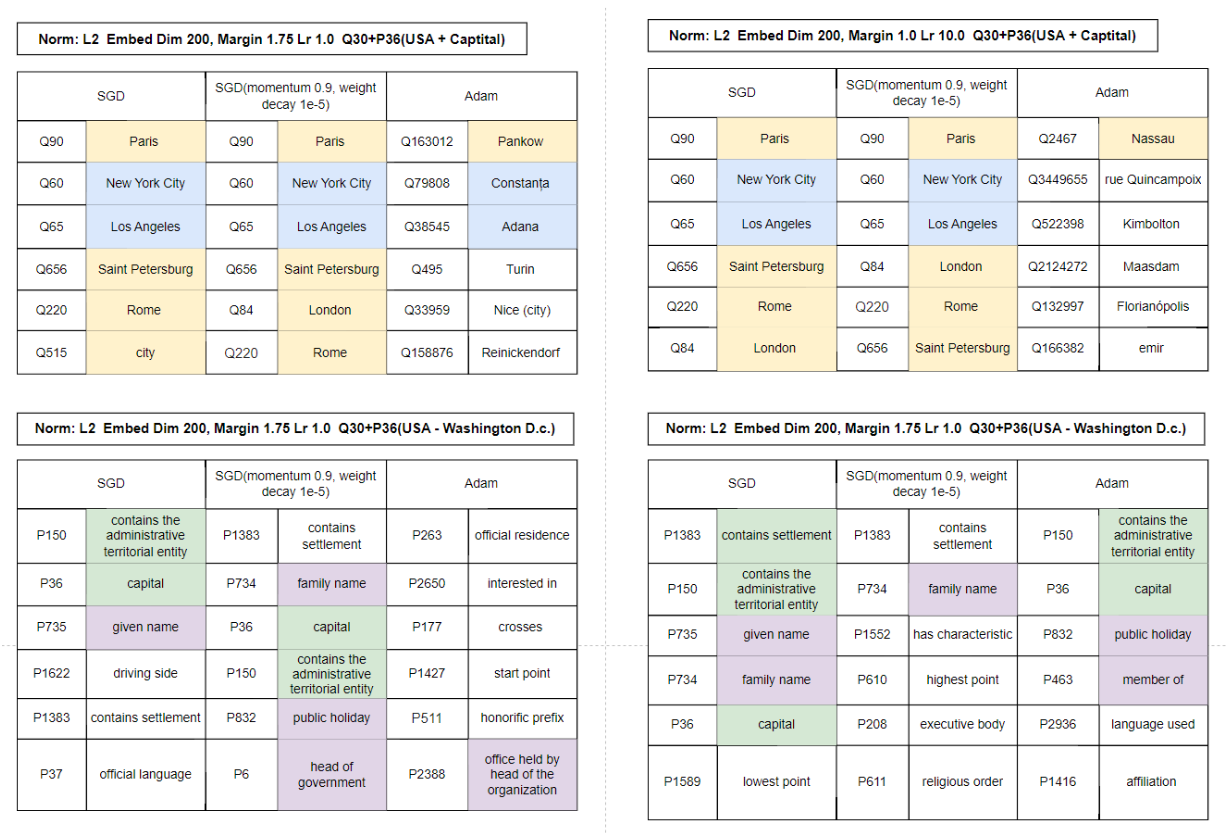  
<i>Color code is the same as Section 1.4.</i>

<b>Observations:</b>  
1. Models with Adam optimizer are the slowest to learn and to converge. They also have the weakest inference on the given entities and relation pair. This phenomenon is very likely caused by underfitting.
2. With higher learning rates, we could see that representation of “Washington” as a name is strengthened in the learned experiences, whilst the word as a city is gradually forgotten(less important).
3. We will use combinations below as our final model:
   * Norm: L2, Embed Dimension: 200, Learning Rate: 1.0, Margin: 1.75 with SGD optimizer. The SGD has momentum 0.9 and weight decay 1e-5.
4. Th model choice is made since the combination:
   * It has successfully built understanding over “capital”.
   * It learns the ambiguous meaning of “Washington” as a name and as a city. It also tries to link these learnt representations to historical/political entities/relationships.  

## 1.6 Final Model  

We use Norm: L2, Embed Dimension: 200, Learning Rate: 1.0, Margin: 1.75 with SGD optimizer. The SGD has momentum 0.9 and weight decay 1e-5 for our final TransE model. Below are attached diagrams for its inference on <USA, capital, ?> and <USA, ?. North America>.  

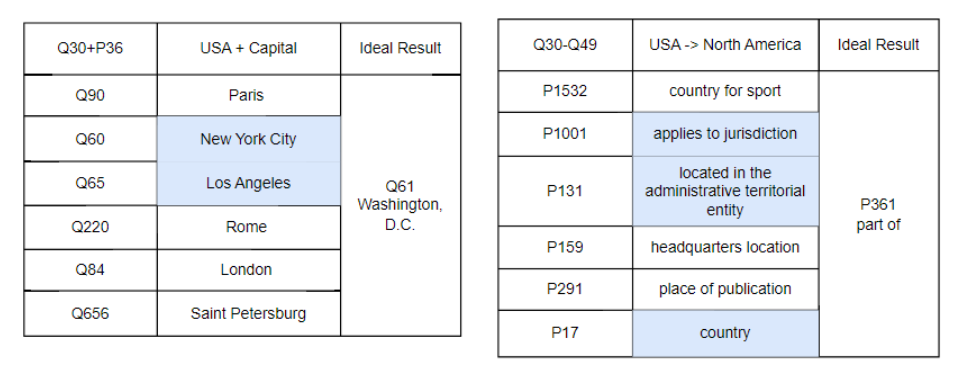  
<i>Highlighted means closer to the expected answers.<</i  

For the given questions: <USA, capital, ?> and <USA, ?. North America>, our final model has successfully understood the “capital”, it could infer capitals of different countries but fail to point out the capital for the United States of America, our given head entity. As for the second question, the ideal answer would be “USA is part of North America”, however, our model fails to calculate relationships that are more closely to “part of”. The inferences that are related to “part of” would be: “applies to jurisdiction”, “located in the administrative territorial entity” and “country”. As “country” is a subproperty of “located in the administrative territorial entity”, we could assume that the model still has not finished learning. In addition, as mentioned in the experiment observations, the political/region related information can be learnt at an early stage of training(with small max epoch). With large epoch amounts, the geographically related information becomes less important, and the model starts to pick up and remember social/society related connections. 



## Summary of Word2Vec and TransE  

In this assignment, we mainly focus on parameter tuning for the TransE and word2vec model. The parameter tuning experiments of the TransE model have major flaws, mainly due to: 1. The training set, verification set and test set are not splitted. The quality of the models only relies on the loss during training and human evaluation of certain individual cases. 2. No evaluation indicators/metrics were used; inspired by online resources, we found an indicator called mean reciprocal rank (MRR), but due to the time limitation, it is not implemented in this assignment. In summary, the experimental completeness of TransE needs to be improved. Loss and evaluation indicators on the verification set and test set need to be introduced to make the quality of parameter adjustment more objective.  

For the Word2Vec model, The best combination among the values we tested are – vector size: 250, window size: 35, minimum count: 10 and max epoch: 16. The best  Spearman's Rank correlation coefficient on the WordSim353  is 0.747125.   
 
For the TransE model, using the L2 norm in our case has better performance than using the L1 norm. The loss gets to 0 at the first training epoch with L1 regularization, and the model stops learning(underfitting) too early. L2 has its nature to force values to be small, but not 0. This allows the TransE model with L2 regularization to learn more. After analyzing the impact of embed dimensions, regularization methods, margins and learning rates on the TransE model, we choose “Norm: L2, Embed Dimension: 200, Learning Rate: 1.0, Margin: 1.75 with SGD optimizer. The SGD has momentum 0.9 and weight decay 1e-5” as our final model. For the given questions: <USA, capital, ?> and <USA, ?. North America>, our final model has successfully understood the “capital”, it could infer capitals of different countries but fail to point out the capital for the United States of America, our given head entity. As for the second question, the ideal answer would be “USA is part of North America”, however, our model fails to calculate relationships that are more closely to “part of”. The inferences that are related to “part of” would be: “applies to jurisdiction”, “located in the administrative territorial entity” and “country”. As “country” is a subproperty of “located in the administrative territorial entity”, we could assume that the model still has not finished learning. In addition, as mentioned in the experiment observations, the political/region related information can be learnt at an early stage of training(with small max epoch). With large epoch amounts, the geographically related information becomes less important, and the model starts to pick up and remember social/society related connections  
. 
During the process of finishing this report, I had a high fever and a serious cold, and therefore there was not enough time left to implement and test any enhancement in Word2Vec and TransE models. An obvious limitation from our experiments suggests that basic Word2Vec and TransE models both have difficulties in word sense ambiguous elimination. It would be a topic that is worth exploring. Also inspired by an article “Improving Knowledge Graph Embedding Using Affine Transformations of Entities Corresponding to Each Relation”, we could also spend some time later to try out the ide  a. 


## Appendix1 Code Snippets to Parameter Tune

In [ ]:

model_loss = []

#config = Config(1, 50, 100, 5, 1.0, 0.01, True)
config = Config(2, 200, 100, 20, 1.75, 5.0, True)
train_dataloader = PyTorchTrainDataLoader(
                        in_path = "./data/", 
                        nbatches = config.nbatches,
                        threads = 8)

transe = TransE(
        ent_tot = train_dataloader.get_ent_tot(),
        rel_tot = train_dataloader.get_rel_tot(),
        dim = config.hidden_size, 
        p_norm = config.p_norm, 
        norm_flag = True,
        margin=config.margin)

optimizier = optim.SGD(transe.parameters(), lr=config.learningRate, momentum=0.9, weight_decay=1e-5)

if config.use_gpu:
    transe.cuda()

loss_no_change_times = 0  # break if 15 continuos no change update iter happens
previous_loss = 0.
delta_loss = 0.

for times in range(config.trainTimes):
    ep_loss = 0.
    
    for data in train_dataloader:
        optimizier.zero_grad()
        score = transe({
                'batch_h': to_var(data['batch_h'], config.use_gpu).long(),
                'batch_t': to_var(data['batch_t'], config.use_gpu).long(),
                'batch_r': to_var(data['batch_r'], config.use_gpu).long()})
        pos_score, neg_score = score[0], score[1]
        loss = transe.loss(pos_score, neg_score)

        # delta loss
        delta_loss = torch.abs(loss - previous_loss)
        print(delta_loss)
        if delta_loss<0.007:
            loss_no_change_times += 1
        else:
            # only continuous 
            loss_no_change_times = 0
        print(loss_no_change_times)
        
        loss.backward()
        optimizier.step()
        ep_loss += loss.item()

        # log model learning data
        model_loss.append(loss.item())
        # update previous loss
        previous_loss = loss

        if loss_no_change_times>20:
            break
    print("Epoch %d | loss: %f" % (times+1, ep_loss))
    if loss_no_change_times>20:
            break

print("Finish Training")

f = open("entity2vec.txt", "w")
enb = transe.ent_embeddings.weight.data.cpu().numpy()
for i in enb:
    for j in i:
        f.write("%f\t" % (j))
    f.write("\n")
f.close()

f = open("relation2vec.txt", "w")
enb = transe.rel_embeddings.weight.data.cpu().numpy()
for i in enb:
    for j in i:
        f.write("%f\t" % (j))
    f.write("\n")
f.close()


In [ ]:
plt.figure()
plt.figure(figsize=(15,10))

x = [i for i in range(len(model_loss))]
plt.xticks(np.arange(1,np.max(x)+1,step=100))
#plt.ylim(0.0, 0.03)

plt.plot(x, model_loss, linestyle='-')
plt.legend()
plt.xlabel('Iters')
plt.ylabel("Loss")
plt.title("Train Loss -- L2 Norm, Embed Dim 200, Margin 1.0, Lr: 10.0")

## Appendix2 Construct Dictionary for Entity and Relation ID and Index

In [4]:
# we need a method to find the entity and relationship ID

entity_file_path = './data/entity2id.txt'
relation_file_path = './data/relation2id.txt'

entity_dict = {}
relation_dict = {}

with open(entity_file_path, 'r') as data:
    for line in data:
        p = line.split()
        if len(p)<2:
            continue
        entity_dict[p[0]] = int(p[1])
with open(relation_file_path, 'r') as data:
    for line in data:
        p = line.split()
        if len(p)<2:
            continue
        relation_dict[p[0]] = int(p[1])

In [5]:
entity_dict['Q30']

118

In [6]:
relation_dict['P36']

20

## Appendix3 Example of Prediction from Learnt Embed Vectors

In [10]:
all_ent = np.loadtxt('entity2vec.txt')
all_rl = np.loadtxt('relation2vec.txt')
q30, p36 = all_ent[118], all_rl[20]  # USA, capital 
q49 = all_ent[26878] # North America
q148 = all_ent[28]
q61 = all_ent[1822]

target = q49 - q30


In [11]:
stack = {}
for idx, e in enumerate(all_ent):
    sim = np.linalg.norm(target-e, 2)
    stack[idx] = sim

In [12]:
list = sorted(stack.items(), key=lambda x: x[1])

In [ ]:
for obj in list[:10]:
    for key, value in entity_dict.items():
        if value == obj[0]:
            print(obj[0], key)
    